In [106]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve
from scipy.linalg import norm
import matplotlib.pyplot as plt
from newton_kantorovich_method import newton_kantorovich_method
plt.rcParams['text.usetex'] = True
# np.set_printoptions(suppress=True)

Given the following BVP
\begin{equation}
\frac{d^2v}{dr^2} + \frac{1}{r}\frac{dv}{dr} - v + 2v^3 = 0
\end{equation}
with boundary conditions
\begin{equation}
\frac{dv}{dr}(0)=0,\quad v(\infty)=0.
\end{equation}
We seek to implement the Newton-Kantorovich method to obtain the monotonically decaying and the one node solutions.

Expressing the BVP as
\begin{equation}
F(v)=
\begin{cases}
v'' + \frac{1}{r} v' - v +2v^3=0 \\
v'(0) = 0\\
v(\infty) = 0
\end{cases}
\end{equation}

The Fréchèt derivative is
\begin{equation}
F^{\,\prime}z =
\begin{cases}
\left[\frac{d^2}{dr^2} + \frac{1}{r} \frac{d}{dr} - 1 + 6v^2\right]z\\
z'(0)\\
z(\infty)
\end{cases}
\end{equation}

Then the Newton-Kantorovich equation $F^{\,\prime}z=-F$ is
\begin{equation}
\begin{cases}
\left[\frac{d^2}{dr^2} + \frac{1}{r} \frac{d}{dr} - 1 + 6v^2\right]z = - \left[ v'' + \frac{1}{r}v' - v + 2v^3\right]\\
z'(0) = -v'(0)\\
z(\infty) = -v(\infty)
\end{cases}
\end{equation}

We now want to solve using finite differences. Let $h$ be the space-step such that
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
so there are $N + 1$ points and $N$ spacings between those points with width $h$. 

In [107]:
a, b = [0.01, 10]
N = 100
h = (b - a)/N
r = np.linspace(a, b, N+1)

We require an ansatz $v(r)$. From the shooting method for the decaying solution

In [108]:
def f(v, r):
    return v[1], -(1/r)*v[1] + v[0] - 2*v[0]**3


pstart, pend = [1.5, 2]
tol = 10**(-6)
diff = np.abs(pend - pstart)
updated_p = 0

while diff > tol:
    updated_p = (pend + pstart)/2
    v0 = [updated_p, 0]
    v = odeint(f, v0, r)

    if v[-1][0] < 0:
        pend = updated_p
    elif v[-1][0] > 0:
        pstart = updated_p

    diff = np.abs(pend - pstart)

v0 = [updated_p, 0]
v = odeint(f, v0, r)
v = v[:,0]
# v = np.exp(-r**2)
v_ansatz = v

Substituting the centered, backward, and forward finite differences into the Newton-Kantorovich equation 
\begin{align}
\frac{z_{j-1} - 2z_j + z_{j+1}}{h^2} + \frac{1}{r}\frac{z_{j+1} - z_{j-1}}{2h}-z_j + 6v_j^2 z_j &= \frac{v_{j-1}-2v_j+v_{j+1}}{h^2} - \frac{1}{r}\frac{v_{j+1} - v_{j-1}}{2h} + v_j - 2v_{j}^3\\
\frac{-3z_1 + 4z_2 - z_3}{2h} &= -\frac{-3v_1 + 4v_2 - v_3}{2h}\\
z_{N+1} &= -v_{N+1}
\end{align}

Expressing the left hand side in terms of $z$ of the new system
\begin{align}
z_j\left(-\frac{2}{h^2} - 1 + 6v_j^2\right) + z_{j-1}\left(\frac{1}{h^2} - \frac{1}{r}\frac{1}{2h}\right)+z_{j+1}\left(\frac{1}{h^2} + \frac{1}{r}\frac{1}{2h}\right) &= -\frac{v_{j-1}-2v_j+v_{j+1}}{h^2} - \frac{1}{r}\frac{v_{j+1} - v_{j-1}}{2h} + v_j - 2v_{j}^3 \\
z_1\left(-\frac{3}{2h}\right) + z_2(2h) + z_3\left(-\frac{1}{2h}\right)&=-\frac{-3v_1 + 4v_2 - v_3}{2h}\\
z_{N+1} &= -v_{N+1}
\end{align}


The system can be expressed as
\begin{equation}
\begin{pmatrix}
-\frac{3}{2h} & 2h & -\frac{1}{2h} & & \cdots & 0\\
\frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6v_2^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} & & \cdots & 0\\
0 & \frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6v_3^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} & \cdots & 0\\
\vdots &  &  &  & & \vdots \\
0 & \cdots & & \frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6v_N^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h}\\
0 & 0 & \cdots & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
z_1\\
z_2\\
z_3\\
\vdots\\
z_{N+1}
\end{pmatrix}
=
\begin{pmatrix}
-\frac{-3v_1 + 4v_2 - v_3}{2h}\\
-\frac{v_1-2v_2+v_3}{h^2} - \frac{1}{r}\frac{v_3 - v_1}{2h} + v_2 - 2v_{2}^3\\
-\frac{v_2-2v_3+v_4}{h^2} - \frac{1}{r}\frac{v_4 - v_2}{2h} + v_3 - 2v_{3}^3\\
\vdots\\
-v_{N+1}
\end{pmatrix}
\end{equation}

Constructing the Jacobian matrix function:

In [109]:
def jacobian_f(N, r, v, h):
    jacobian = np.zeros((N + 1, N + 1))

    jacobian[(0, 0)] = -3
    jacobian[(0, 1)] = 4
    jacobian[(0, 2)] = -1
    jacobian[(N, N)] = 1

    diag_1 = []
    diag_2 = []
    diag_3 = []

    for i in range(1, N):
        diag_1.append(1 / (h ** 2) - (1 / r[i]) * (1 / (2 * h)))
        diag_2.append(-2 / (h ** 2) - 1 + 6 * v[i] ** 2)
        diag_3.append(1 / (h ** 2) + (1 / r[i]) * (1 / (2 * h)))

    np.fill_diagonal(jacobian[1:, :N - 1], diag_1)
    np.fill_diagonal(jacobian[1:N, 1:N], diag_2)
    np.fill_diagonal(jacobian[1:N + 1, 2:N + 1], diag_3)

    return jacobian

Creating the $F$ vector function:

In [110]:
def f_vec(N, r, v, h):
    F = np.zeros(N + 1)
    F[0] = -(-3 * v[0] + 4 * v[1] - v[2])
    F[N] = -v[N]
    # F[N] = 0

    for i in range(1, N):
        F[i] = -(v[i - 1] - 2 * v[i] + v[i + 1]) / (h ** 2) - (1 / r[i]) * ((v[i + 1] - v[i - 1]) / (2 * h)) + v[
            i] - 2 * v[i] ** 3

    return F

Now we can create a while loop that will iteratively solve for the vector $\vec{v}$ with corrections $\vec{z}$:

In [111]:
tol = 10 ** (-6)
n_iterations = 0
F = f_vec(N, r, v, h)

while norm(F) > tol and n_iterations < 100:
    jacobian = jacobian_f(N, r, v, h)
    z = solve(jacobian, F)
    v = v + z
    F = f_vec(N, r, v, h)
    n_iterations = n_iterations + 1

We can now plot the ansatz $v_\text{ansatz}$ and the solved $v_\text{NK}$:

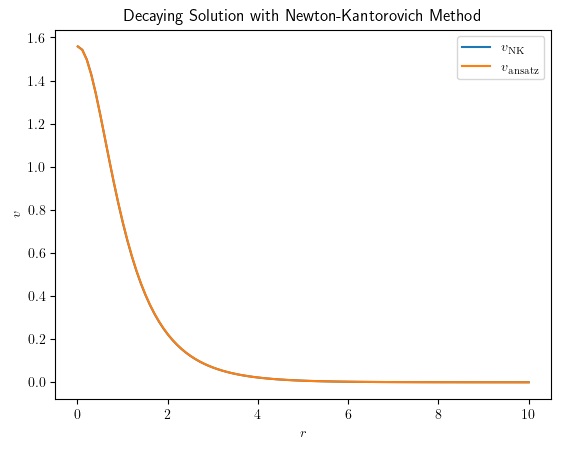

In [112]:
plt.plot(r, v, label=r'$v_\mathrm{NK}$')
plt.plot(r, v_ansatz, label=r'$v_\mathrm{ansatz}$')
plt.xlabel(r'$r$')
plt.ylabel(r'$v$')
plt.title(r'Decaying Solution with Newton-Kantorovich Method')
plt.legend()
plt.show()

We can now consider the effects of choosing a different ansatz
\begin{equation}
v_\text{ansatz}(r)=e^{-r^2}
\end{equation}

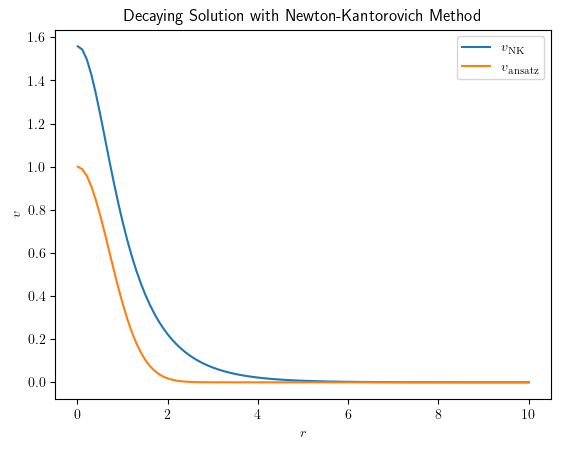

In [113]:
v = np.exp(-r**2)
v_ansatz = v
v, n_iterations = newton_kantorovich_method(N, r, v, h, tol)
plt.plot(r, v, label=r'$v_\mathrm{NK}$')
plt.plot(r, v_ansatz, label=r'$v_\mathrm{ansatz}$')
plt.xlabel(r'$r$')
plt.ylabel(r'$v$')
plt.title(r'Decaying Solution with Newton-Kantorovich Method')
plt.legend()
plt.show()

We can now determine the one-node solution. Using the ansatz found in the shooting method for the one-node solution:

In [114]:
pstart, pend = [2.33, 2.39]
tol = 10**(-6)
diff = np.abs(pend - pstart)

while diff > tol:
    updated_p = (pend + pstart)/2
    v0 = [updated_p, 0]
    v = odeint(f, v0, r)

    if v[-1][0] > 0:
        pend = updated_p
    elif v[-1][0] < 0:
        pstart = updated_p

    diff = np.abs(pend - pstart)

v0 = [updated_p, 0]
v = odeint(f, v0, r)
v = v[:,0]
v_ansatz = v

We can now find $v_{\text{NK}}$ and plot the results

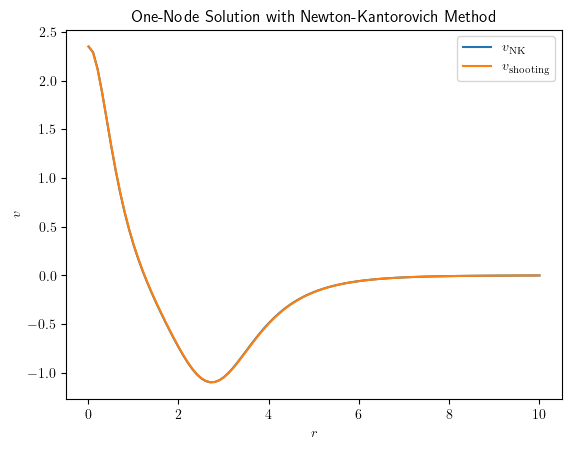

In [115]:
v, n_iterations = newton_kantorovich_method(N, r, v, h, tol)
plt.plot(r, v, label=r'$v_\mathrm{NK}$')
plt.plot(r, v_ansatz, label=r'$v_\mathrm{shooting}$')
plt.xlabel(r'$r$')
plt.ylabel(r'$v$')
plt.title(r'One-Node Solution with Newton-Kantorovich Method')
plt.legend()
plt.show()

We can now consider the effects of choosing a different ansatz
\begin{equation}
v_\text{ansatz}(r) = -e^{-(r-2)^2} + 2e^{-2r^2}
\end{equation}

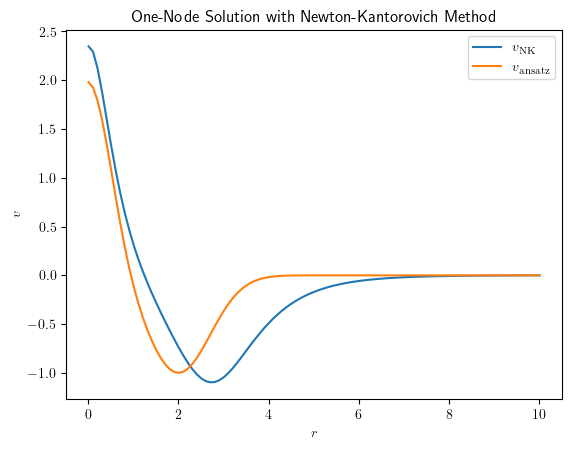

In [116]:
# v = - 1*np.exp(-r**2) + 3*np.exp(-4*r**3)
v = -np.exp(-1*(r-2)**2) + 2*np.exp(-2*r**2)
v_ansatz = v
v, n_iterations = newton_kantorovich_method(N, r, v, h, tol)
plt.plot(r, v, label=r'$v_\mathrm{NK}$')
plt.plot(r, v_ansatz, label=r'$v_\mathrm{ansatz}$')
plt.xlabel(r'$r$')
plt.ylabel(r'$v$')
plt.title(r'One-Node Solution with Newton-Kantorovich Method')
plt.legend()
plt.show()